In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# import mne
import numpy as np
# from copy import deepcopy
# import matplotlib.pyplot as plt
import sys; sys.path.insert(0, '../')
from esinet import util
from esinet import Simulation
from esinet import Net
from esinet.forward import create_forward_model, get_info
from scipy.stats import pearsonr
from matplotlib import pyplot as plt
plot_params = dict(surface='white', hemi='both', verbose=0)

## Create Forward model
First we create a template forward model which comes with the esinet package

In [2]:
info = get_info(sfreq=100, kind="biosemi64")
fwd = create_forward_model(sampling="ico3", info=info)
_, pos = util.unpack_fwd(fwd)[1:3]
leadfield = fwd["sol"]["data"]
n_chans, n_dipoles = leadfield.shape

import mne
from scipy.sparse.csgraph import laplacian

adjacency = mne.spatial_src_adjacency(fwd['src']).toarray()
laplace_operator = abs(laplacian(adjacency))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    2.5s remaining:    2.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


-- number of adjacent vertices : 1284


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished


# Defs

In [3]:
def prep_data(X, y):
    X = np.stack([(x - np.mean(x)) / np.std(x) for x in X], axis=0)
    y = np.stack([(x / np.max(abs(x))) for x in y], axis=0)
    return X, y

# Simulate

In [4]:
settings = dict(duration_of_trial=0.25, extents=(1,40), number_of_sources=(1,15), target_snr=1e99)
sim = Simulation(fwd, info, settings=settings).simulate(n_samples=2000)
X = np.stack([eeg.average().data for eeg in sim.eeg_data], axis=0)
y = np.stack([source.data for source in sim.source_data], axis=0)
X, y = prep_data(X, y)
X = np.swapaxes(X, 1, 2)
y = np.swapaxes(y, 1, 2)

Simulating data based on sparse patches.


100%|██████████| 2000/2000 [00:37<00:00, 52.73it/s]


# Model

## Create

In [50]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, InputLayer, Input, Lambda, LayerNormalization, GRU, multiply
from tensorflow.keras.layers import Activation, Dropout, ActivityRegularization, TimeDistributed, Reshape, Permute, GaussianNoise, add
import numpy as np
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
# import tensorflow_probability as tfp
from tensorflow.keras.regularizers import l1, l2, l1_l2
K.set_image_data_format('channels_last')

def data_loss(leadfield, lam_0=0.1):
    leadfield_ = tf.cast(leadfield, dtype=tf.float32)
    def batch_data_loss(y_true, y_est):
        def d_loss(y_true, y_est):
            y_true_eeg = tf.transpose(tf.matmul(leadfield_, tf.transpose(y_true)))
            y_est_eeg = tf.transpose(tf.matmul(leadfield_, tf.transpose(y_est)))
            # print("y_true ", y_true)
            # print("y_est ", y_est)
            
            # return K.mean(K.square(y_est - y_true))
            error_source = tf.keras.losses.CosineSimilarity(name="Data_Cosine_Loss")(y_est, y_true)
            error_eeg = tf.keras.losses.CosineSimilarity(name="Data_Cosine_Loss")(y_est_eeg, y_true_eeg)
            return (error_source*lam_0 + error_eeg) / (1 + lam_0)
        
        

        batched_losses = tf.map_fn(lambda x:
            d_loss(x[0], x[1]), 
            (y_true, y_est), dtype=tf.float32)
        return K.mean(batched_losses)


    return batch_data_loss


def consistency(x):
    return K.mean(K.std(K.abs(x), axis=1))

# def consistency(source):
#     def c_loss(x):
#         matrix = compute_cosine_distances(K.abs(x), K.abs(x))
#         return K.mean(matrix)


#     batched_losses = tf.map_fn(lambda x:
#             c_loss(x), 
#             source, dtype=tf.float32)
#     return K.mean(batched_losses)

def c_loss(sources):
    matrix = K.abs(compute_cosine_distances(K.abs(sources), K.abs(sources)))
    return K.mean(matrix)


def compute_cosine_distances(a, b):
    # x shape is n_a * dim
    # y shape is n_b * dim
    # results shape is n_a * n_b

    normalize_a = tf.nn.l2_normalize(a,-1)        
    normalize_b = tf.nn.l2_normalize(b,-1)
    distance = 1 - tf.matmul(normalize_a, normalize_b, transpose_b=True)
    return distance


def l1_sparsity(x):
    return K.mean(K.abs(x)) 

def get_model(name="Model", n_dense_layers=2, hidden_units=200, learning_rate=0.001, lam_0=0.1, lam_1=1, lam_2=0.001, add_consistency=True):
    input_shape = (None, n_chans)
    leadfield_ = tf.cast(leadfield, dtype=tf.float32)
    inputs = tf.keras.Input(shape=input_shape, name=name)
    fc = TimeDistributed(Dense(hidden_units, activation="linear", name="FC1"))(inputs)

    gru = GRU(64, return_sequences=True, name='GRU_Discriminator')(inputs)
    source_time = TimeDistributed(Dense(n_dipoles, activation="sigmoid", name="Mask"))(gru)

    source = TimeDistributed(Dense(n_dipoles, activation="linear", name="Output_Final"))(fc)

    out = multiply([source_time, source])
    print(out)
    # out = Lambda(lambda x: tf.transpose(tf.linalg.matmul(leadfield_, tf.transpose(x))), output_shape=(None, n_chans))(source)
    # # out = TimeDistributed(Lambda(lambda x: tf.transpose(tf.linalg.matmul(leadfield_, tf.transpose(x))), output_shape=(None, n_chans)))(source)
    
    
    model = tf.keras.Model(inputs=inputs, outputs=out, name='CS_Net')
    
    # Data Loss
    # L1 Loss
    model.add_loss(l1_sparsity(out)*lam_1)
    
    # Data consistency loss
    if add_consistency:
        model.add_loss(c_loss(out)*lam_2)
    
    model.compile(loss=data_loss(leadfield, lam_0=lam_0), optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    # model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    
    return model



## Train

In [52]:
lams_0 = [0.1, ]
lams_1 = [1, ]
lams_2 = [0.01, ]

models = []
for lam_0, lam_1, lam_2 in zip(lams_0, lams_1, lams_2):
    model = get_model(lam_0=lam_0, lam_1=lam_1, lam_2=lam_2, name=f"Lam {lam_2}")
    model.fit(X, y, epochs=20, batch_size=8, validation_split=0.1)
    models.append(model)


KerasTensor(type_spec=TensorSpec(shape=(None, None, 1284), dtype=tf.float32, name=None), name='multiply_5/mul:0', description="created by layer 'multiply_5'")
Epoch 1/20


In [47]:
models = [model,]

## Evaluate

In [ ]:
from esinet.evaluate import eval_auc
from scipy.stats import pearsonr
sim_test = Simulation(fwd, info, settings=settings).simulate(n_samples=2)
idx = 0
stc = sim_test.source_data[idx].copy()
stc.plot(**plot_params)

for mod in models:
    src_hat = mod.predict(X)[idx]
    stc_hat = stc.copy()
    stc_hat.data = src_hat.T
    stc_hat.plot(**plot_params)
    auc = np.mean([np.mean(eval_auc(y_true_sample, y_pred_sample, pos)) for y_true_sample, y_pred_sample in zip(stc.data.T, stc_hat.data.T)])
    corrs = np.mean([np.mean(pearsonr(y_true_sample, y_pred_sample)[0]) for y_true_sample, y_pred_sample in zip(stc.data.T, stc_hat.data.T)])
    nmses = np.mean([np.mean((y_true_sample - y_pred_sample)**2) for y_true_sample, y_pred_sample in zip(stc.data.T, stc_hat.data.T)])
    
    print("AUC: ", auc, " Corrs: ", corrs, " nMSE: ", nmses)

Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 55.70it/s]


AUC:  0.4506545454545454  Corrs:  -0.013988784125806055  nMSE:  0.0002984057234285125


Using control points [0.02454895 0.04213159 0.11234727]
Using control points [0.00000000e+00 0.00000000e+00 3.14025451e-08]
Using control points [0.05798654 0.10227946 0.33669638]


# Evaluate New

In [48]:
from esinet.evaluate import eval_auc
from scipy.stats import pearsonr
# settings = dict(duration_of_trial=0.25, extents=(1,40), number_of_sources=(1,15), target_snr=1e99)
settings = dict(duration_of_trial=0.25, extents=20, number_of_sources=1, target_snr=1e99)

sim_test = Simulation(fwd, info, settings=settings).simulate(n_samples=2)

X_test = np.stack([eeg.average().data for eeg in sim_test.eeg_data], axis=0)
y_test = np.stack([source.data for source in sim_test.source_data], axis=0)
X_test, y_test = prep_data(X_test, y_test)
X_test = np.swapaxes(X_test, 1, 2)
y_test = np.swapaxes(y_test, 1, 2)


idx = 0
stc = sim_test.source_data[idx].copy()
stc.data /= np.max(abs(stc.data))
stc.plot(**plot_params)

for model in models:
    src_hat = model.predict(X_test)[idx]
    stc_hat = stc.copy()
    stc_hat.data = src_hat.T
    stc_hat.data /= np.max(abs(stc_hat.data))
    stc_hat.plot(**plot_params)
    auc = np.mean([np.mean(eval_auc(y_true_sample, y_pred_sample, pos)) for y_true_sample, y_pred_sample in zip(stc.data.T, stc_hat.data.T)])
    corrs = np.mean([np.mean(pearsonr(y_true_sample, y_pred_sample)[0]) for y_true_sample, y_pred_sample in zip(stc.data.T, stc_hat.data.T)])
    nmses = np.mean([np.mean((y_true_sample - y_pred_sample)**2) for y_true_sample, y_pred_sample in zip(stc.data.T, stc_hat.data.T)])
    
    print(model.name, " AUC: ", auc, " Corrs: ", corrs, " nMSE: ", nmses, "\n")

Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 55.70it/s]


CS_Net  AUC:  0.9762000000000001  Corrs:  0.1828618053288864  nMSE:  0.006708810981980628 



(array([  8.,   0.,   0.,   0., 312.,   0.,  85.,   0., 181.,  39.]),
 array([-2.22044605e-16, -1.66533454e-16, -1.11022302e-16, -5.55111512e-17,
         0.00000000e+00,  5.55111512e-17,  1.11022302e-16,  1.66533454e-16,
         2.22044605e-16,  2.77555756e-16,  3.33066907e-16]),
 <BarContainer object of 10 artists>)

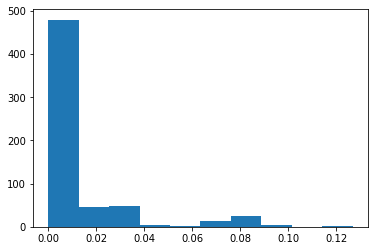

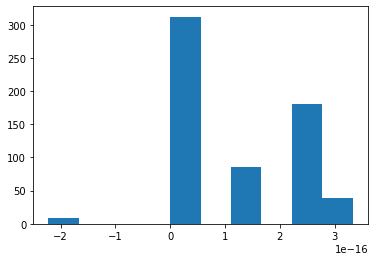

Using control points [1.99267993e-08 1.85261041e-06 3.01261865e-02]
Using control points [0.16313677 0.1865924  0.31465007]
Using control points [0.28877792 0.36436045 0.82884548]
Using control points [0.28877792 0.36436045 0.82884548]
Using control points [1.99267993e-08 1.85261041e-06 3.01261865e-02]
Using control points [0.16410797 0.2065051  0.46552234]
Using control points [0.16410797 0.2065051  0.46552234]
Using control points [0.30574767 0.38696716 0.87798761]


In [49]:
plt.figure()
plt.hist(compute_cosine_distances(abs(stc_hat.data.T), abs(stc_hat.data.T)).numpy().flatten())

plt.figure()
plt.hist(compute_cosine_distances(abs(stc.data.T), abs(stc.data.T)).numpy().flatten())

In [42]:
compute_cosine_distances(abs(stc.data.T), abs(stc.data.T)).numpy()

array([[ 2.22044605e-16,  2.22044605e-16,  2.22044605e-16,
         1.11022302e-16,  2.22044605e-16,  2.22044605e-16,
         2.22044605e-16,  1.11022302e-16,  2.22044605e-16,
         2.22044605e-16,  1.11022302e-16,  2.22044605e-16,
         1.11022302e-16,  1.11022302e-16,  1.11022302e-16,
         1.11022302e-16,  1.11022302e-16,  2.22044605e-16,
         1.11022302e-16,  2.22044605e-16,  1.11022302e-16,
         1.11022302e-16,  1.11022302e-16,  2.22044605e-16,
         1.11022302e-16],
       [ 2.22044605e-16,  2.22044605e-16,  2.22044605e-16,
         1.11022302e-16,  2.22044605e-16,  2.22044605e-16,
         2.22044605e-16,  1.11022302e-16,  2.22044605e-16,
         2.22044605e-16,  1.11022302e-16,  2.22044605e-16,
         1.11022302e-16,  1.11022302e-16,  1.11022302e-16,
         1.11022302e-16,  1.11022302e-16,  2.22044605e-16,
         1.11022302e-16,  2.22044605e-16,  1.11022302e-16,
         1.11022302e-16,  1.11022302e-16,  2.22044605e-16,
         1.11022302e-16],
    

In [ ]:
sys.path.insert(0, '../../invert/')
from invert.solvers.minimum_norm_estimates import SolverDynamicStatisticalParametricMapping, SolverMinimumNorm
from invert.solvers.wrop import SolverLAURA
from invert.solvers.empirical_bayes import SolverChampagne

# solver = SolverLAURA().make_inverse_operator(fwd)
solver = SolverChampagne().make_inverse_operator(fwd)
# solver = SolverMinimumNorm().make_inverse_operator(fwd)

stc_mne = solver.apply_inverse_operator(sim_test.eeg_data[0].average())
stc_mne.data = stc_mne.data / np.max(abs(stc_mne.data))
stc_mne.plot(**plot_params, brain_kwargs=dict(title=solver.name))
auc = np.mean([np.mean(eval_auc(y_true_sample, y_pred_sample, pos)) for y_true_sample, y_pred_sample in zip(stc.data.T, stc_mne.data.T)])
corrs = np.mean([np.mean(pearsonr(y_true_sample, y_pred_sample)[0]) for y_true_sample, y_pred_sample in zip(stc.data.T, stc_mne.data.T)])
nmses = np.mean([np.mean((y_true_sample - y_pred_sample)**2) for y_true_sample, y_pred_sample in zip(stc.data.T, stc_mne.data.T)])

print(model.name, " AUC: ", auc, " Corrs: ", corrs, " nMSE: ", nmses, "\n")

CS_Net  AUC:  0.8378210112213429  Corrs:  0.7222753552536002  nMSE:  0.0006593505864149563 



Using control points [0.09355759 0.12046235 0.51585314]
Using control points [0.09003848 0.10991064 0.52070489]
Using control points [0.08965538 0.11320082 0.38877619]
Using control points [0.0851066  0.09752246 0.21187828]
Using control points [0.07968308 0.09179646 0.23420075]
Using control points [0.12812387 0.17138633 0.88748322]
Using control points [0.12812387 0.17138633 0.88748322]
Using control points [0.11990799 0.16882805 0.88780172]
Using control points [0.11927841 0.15267209 0.64830078]
Using control points [0.00000000e+00 3.64393098e-09 5.85266263e-08]
Using control points [0.         0.01178944 0.34447401]
